In [6]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns


   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

   cat_contract  cat_region  cat_payment  te

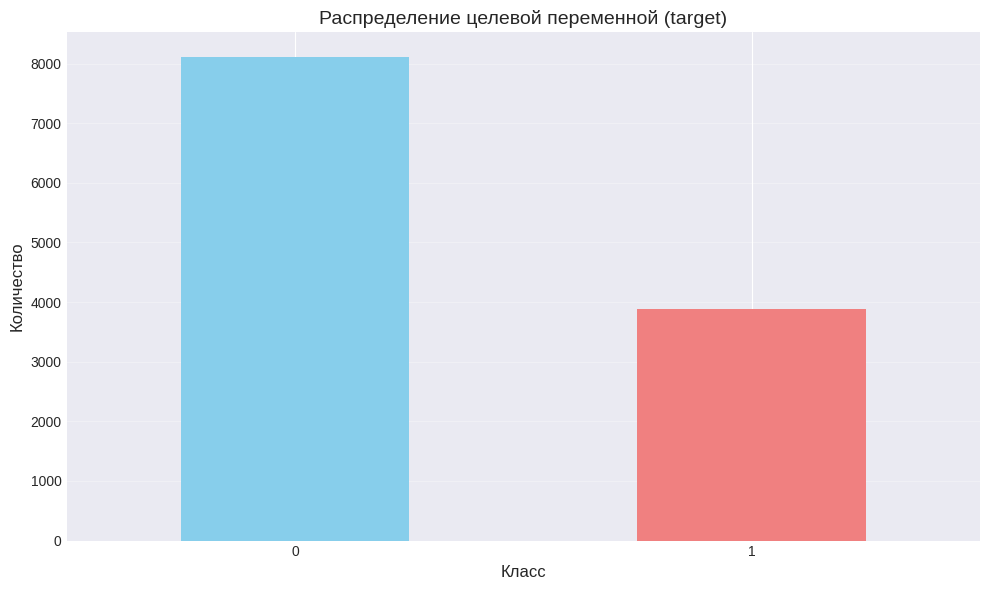

Столбец 'id' найден и будет исключен из признаков

Размерность матрицы признаков X: (12000, 28)
Размерность целевого вектора y: (12000,)

Первые 5 признаков (столбцов):
['num01', 'num02', 'num03', 'num04', 'num05']

Типы данных признаков:
float64    24
int64       4
Name: count, dtype: int64


In [7]:
df = pd.read_csv('S06-hw-dataset-01.csv')

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

#Основная информация
print(df.head())
print(df.info())
print(df.describe())

# Проверка пропусков
print("4. ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
print("=" * 60)
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("Пропущенных значений не обнаружено!")

# Анализ распределения таргета
target_distribution = df['target'].value_counts(normalize=True) * 100
print("Процентное распределение:")
print(target_distribution)

print("\nАбсолютные значения:")
print(df['target'].value_counts())

# Визуализация распределения таргета
plt.figure(figsize=(10, 6))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение целевой переменной (target)', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#  Определение признаков и таргета
columns_to_drop = ['target']
if 'id' in df.columns:
    columns_to_drop.append('id')
    print("Столбец 'id' найден и будет исключен из признаков")

X = df.drop(columns=columns_to_drop)
y = df['target']

print(f"\nРазмерность матрицы признаков X: {X.shape}")
print(f"Размерность целевого вектора y: {y.shape}")

print("\nПервые 5 признаков (столбцов):")
print(X.columns[:5].tolist() if len(X.columns) > 5 else X.columns.tolist())

print("\nТипы данных признаков:")
print(X.dtypes.value_counts())


# Сохранение результатов для дальнейшего использования
data_info = {
    'X': X,
    'y': y,
    'feature_names': X.columns.tolist(),
    'target_name': 'target',
    'n_samples': X.shape[0],
    'n_features': X.shape[1],
    'n_classes': len(y.unique()),
    'class_distribution': dict(df['target'].value_counts())
}

Обучающая выборка (X_train, y_train): (9600, 28), (9600,)
Тестовая выборка (X_test, y_test): (2400, 28), (2400,)
Исходные данные (X, y): (12000, 28), (12000,)


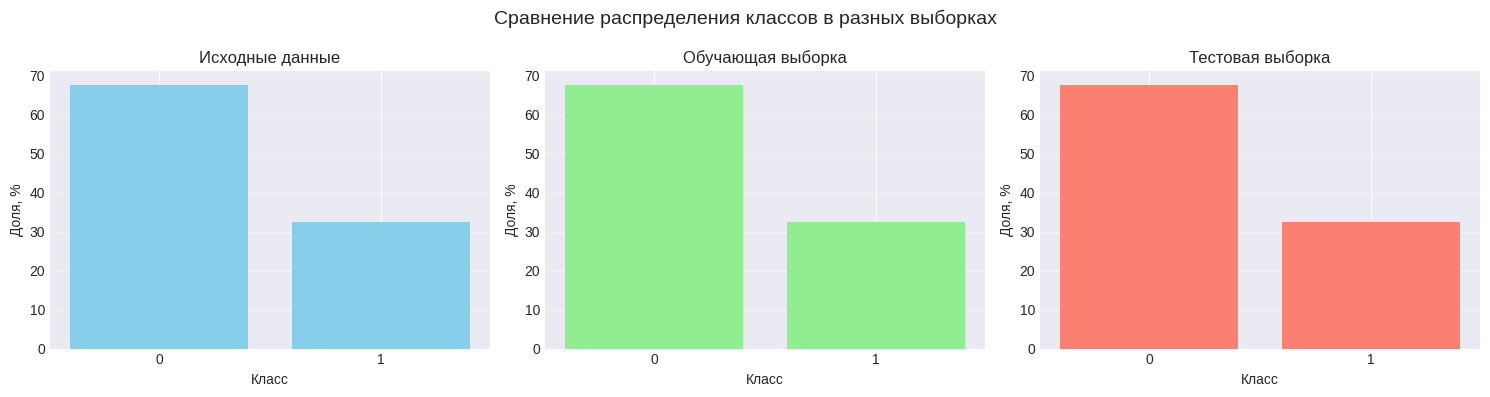


Фиксированный seed гарантирует воспроизводимость результатов и позволяет использовать один датасет для разных моделей
Стратификация сохраняет пропорции классов в train и test выборках и особенно важна при дисбалансе классов

Обучающая выборка 9600 примеров (80.0%)
Тестовая выборка  2400 примеров (20.0%)
Random_state = 42


In [8]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X,                    # признаки
    y,                    # таргет
    test_size=TEST_SIZE,  # доля тестовой выборки
    random_state=RANDOM_STATE,  # фиксируем случайное состояние
    stratify=y,           # стратификация по таргету
    shuffle=True          # перемешивание данных перед разделением
)

# Проверка размеров выборок
print(f"Обучающая выборка (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка (X_test, y_test): {X_test.shape}, {y_test.shape}")
print(f"Исходные данные (X, y): {X.shape}, {y.shape}")

# Распределение в исходных данных
orig_dist = y.value_counts(normalize=True).sort_index()

# Распределение в обучающей выборке
train_dist = y_train.value_counts(normalize=True).sort_index()

# Распределение в тестовой выборке
test_dist = y_test.value_counts(normalize=True).sort_index()

# Создаем DataFrame для наглядного сравнения
dist_comparison = pd.DataFrame({
    'Исходные данные': orig_dist,
    'Обучающая выборка': train_dist,
    'Тестовая выборка': test_dist
})


# Визуализация распределения классов
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Исходные данные
axes[0].bar(orig_dist.index.astype(str), orig_dist.values * 100, color='skyblue')
axes[0].set_title('Исходные данные')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Доля, %')
axes[0].grid(axis='y', alpha=0.3)

# Обучающая выборка
axes[1].bar(train_dist.index.astype(str), train_dist.values * 100, color='lightgreen')
axes[1].set_title('Обучающая выборка')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Доля, %')
axes[1].grid(axis='y', alpha=0.3)

# Тестовая выборка
axes[2].bar(test_dist.index.astype(str), test_dist.values * 100, color='salmon')
axes[2].set_title('Тестовая выборка')
axes[2].set_xlabel('Класс')
axes[2].set_ylabel('Доля, %')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Сравнение распределения классов в разных выборках', fontsize=14)
plt.tight_layout()
plt.show()

print("""
Фиксированный seed гарантирует воспроизводимость результатов и позволяет использовать один датасет для разных моделей
Стратификация сохраняет пропорции классов в train и test выборках и особенно важна при дисбалансе классов
""")

# Сохранение разделенных данных для дальнейшего использования

print(f"Обучающая выборка {len(X_train)} примеров ({len(X_train)/len(X)*100:.1f}%)")
print(f"Тестовая выборка  {len(X_test)} примеров ({len(X_test)/len(X)*100:.1f}%)")
print(f"Random_state = {RANDOM_STATE}")

# Сохраняем результаты в словарь для использования в следующих шагах
split_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Функция для вычисления метрик
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Обучает модель и вычисляет метрики"""
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания
    y_pred = model.predict(X_test)

    # Вероятности (если модель поддерживает)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        if len(y_proba.shape) > 1 and y_proba.shape[1] > 1:
            y_proba = y_proba[:, 1] if y_proba.shape[1] == 2 else y_proba
    else:
        y_proba = None

    # Вычисление метрик
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    # ROC-AUC только для бинарной классификации с вероятностями
    if y_proba is not None:
        if len(np.unique(y_test)) == 2 and y_proba.ndim == 1:
            metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
        elif len(np.unique(y_test)) > 2 and y_proba.ndim == 2:
            # Multi-class ROC-AUC OVR
            metrics['roc_auc'] = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

    return metrics, y_pred, y_proba


In [11]:
# 1. DummyClassifier (baseline)
print("\n1. DummyClassifier (стратегия 'stratified'):")
print("-" * 40)

dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_metrics, dummy_pred, _ = evaluate_model(
    dummy_model, X_train, y_train, X_test, y_test,
    "DummyClassifier"
)

print(f"Accuracy: {dummy_metrics['accuracy']:.4f}")
print(f"F1-score: {dummy_metrics['f1']:.4f}")
print("Модель предсказывает случайно, сохраняя распределение классов")
print("Это минимальный уровень, который должна преодолеть настоящая модель")



1. DummyClassifier (стратегия 'stratified'):
----------------------------------------
Accuracy: 0.5754
F1-score: 0.5749
Модель предсказывает случайно, сохраняя распределение классов
Это минимальный уровень, который должна преодолеть настоящая модель


In [12]:
# 2. LogisticRegression (baseline)
print("\n\n2. LogisticRegression со StandardScaler:")
print("-" * 40)
# Создаем pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'  # учитываем дисбаланс
    ))
])

logreg_metrics, logreg_pred, logreg_proba = evaluate_model(
    logreg_pipeline, X_train, y_train, X_test, y_test,
    "LogisticRegression"
)

print(f"Accuracy: {logreg_metrics['accuracy']:.4f}")
print(f"F1-score: {logreg_metrics['f1']:.4f}")
if 'roc_auc' in logreg_metrics:
    print(f"ROC-AUC: {logreg_metrics['roc_auc']:.4f}")

# Сравнение baseline'ов
print("\n" + "=" * 60)
print("СРАВНЕНИЕ BASELINE МОДЕЛЕЙ:")
print("=" * 60)

baseline_metrics_df = pd.DataFrame([dummy_metrics, logreg_metrics])
print(baseline_metrics_df.set_index('model').round(4))



2. LogisticRegression со StandardScaler:
----------------------------------------
Accuracy: 0.8054
F1-score: 0.8088
ROC-AUC: 0.8763

СРАВНЕНИЕ BASELINE МОДЕЛЕЙ:
                    accuracy      f1  roc_auc
model                                        
DummyClassifier       0.5754  0.5749   0.5137
LogisticRegression    0.8054  0.8088   0.8763


In [14]:
# 2.3.4. Модели недели 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Функция для подбора гиперпараметров
def tune_model(model, param_grid, X_train, y_train, cv=5):
    """Выполняет поиск по сетке гиперпараметров"""
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='roc_auc' if len(np.unique(y_train)) == 2 else 'f1_macro',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    return grid_search

In [15]:
# 1. DecisionTreeClassifier
print("\n1. DecisionTreeClassifier:")
print("-" * 40)

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

# Сетка гиперпараметров для контроля сложности
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

print("Подбор гиперпараметров...")
dt_grid = tune_model(dt_model, dt_param_grid, X_train, y_train)
print(f"Лучшие параметры: {dt_grid.best_params_}")
print(f"Лучший CV-score: {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_
dt_metrics, dt_pred, dt_proba = evaluate_model(
    dt_best, X_train, y_train, X_test, y_test,
    "DecisionTree"
)


1. DecisionTreeClassifier:
----------------------------------------
Подбор гиперпараметров...
Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Лучший CV-score: 0.9083


In [16]:
# 2. RandomForestClassifier
print("\n\n2. RandomForestClassifier:")
print("-" * 40)

rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],  # контроль разнообразия деревьев
    'bootstrap': [True, False]
}

print("Подбор гиперпараметров...")
rf_grid = tune_model(rf_model, rf_param_grid, X_train, y_train)
print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучший CV-score: {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_
rf_metrics, rf_pred, rf_proba = evaluate_model(
    rf_best, X_train, y_train, X_test, y_test,
    "RandomForest"
)



2. RandomForestClassifier:
----------------------------------------
Подбор гиперпараметров...
Лучшие параметры: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}
Лучший CV-score: 0.9720


In [ ]:
# 3. GradientBoostingClassifier
print("\n\n3. GradientBoostingClassifier:")
print("-" * 40)

gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

print("Подбор гиперпараметров...")
gb_grid = tune_model(gb_model, gb_param_grid, X_train, y_train)
print(f"Лучшие параметры: {gb_grid.best_params_}")
print(f"Лучший CV-score: {gb_grid.best_score_:.4f}")

gb_best = gb_grid.best_estimator_
gb_metrics, gb_pred, gb_proba = evaluate_model(
    gb_best, X_train, y_train, X_test, y_test,
    "GradientBoosting"
)



3. GradientBoostingClassifier:
----------------------------------------
Подбор гиперпараметров...


In [ ]:
# 4. StackingClassifier
print("\n\n4. StackingClassifier:")
print("-" * 40)

# Базовые модели для стекинга
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

base_models = [
    ('dt', DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    )),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]
# Мета-модель
meta_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Создаем stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # Используем CV для обучения базовых моделей
    n_jobs=-1,
    passthrough=True  # Используем и исходные признаки тоже
)

print("Обучение StackingClassifier (может занять время)...")
stacking_metrics, stacking_pred, stacking_proba = evaluate_model(
    stacking_model, X_train, y_train, X_test, y_test,
    "Stacking"
)

# Сбор всех метрик
print("\n" + "=" * 60)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
print("=" * 60)

all_metrics = [
    dummy_metrics,
    logreg_metrics,
    dt_metrics,
    rf_metrics,
    gb_metrics,
    stacking_metrics
]

metrics_df = pd.DataFrame(all_metrics).set_index('model')
print(metrics_df.round(4))

In [ ]:
# 2.3.5. Метрики качества и диагностика

from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Определяем лучшую модель
if 'roc_auc' in metrics_df.columns:
    best_model_name = metrics_df['roc_auc'].idxmax()
else:
    best_model_name = metrics_df['f1'].idxmax()

print(f"Лучшая модель: {best_model_name}")

# Получаем объект лучшей модели
best_model_metrics = metrics_df.loc[best_model_name]
print(f"Метрики лучшей модели:\n{best_model_metrics}")

# Визуализации для лучшей модели
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix
if best_model_name == "DummyClassifier":
    y_pred_best = dummy_pred
elif best_model_name == "LogisticRegression":
    y_pred_best = logreg_pred
elif best_model_name == "DecisionTree":
    y_pred_best = dt_pred
elif best_model_name == "RandomForest":
    y_pred_best = rf_pred
elif best_model_name == "GradientBoosting":
    y_pred_best = gb_pred
else:
    y_pred_best = stacking_pred

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=axes[0])
axes[0].set_title(f'Confusion Matrix - {best_model_name}')

# 2. ROC Curve (только для бинарной классификации)
if len(np.unique(y_test)) == 2:
    # Получаем вероятности для лучшей модели
    if best_model_name == "LogisticRegression":
        y_proba_best = logreg_proba
    elif best_model_name == "DecisionTree":
        y_proba_best = dt_proba[:, 1] if dt_proba.ndim > 1 else dt_proba
    elif best_model_name == "RandomForest":
        y_proba_best = rf_proba[:, 1] if rf_proba.ndim > 1 else rf_proba
    elif best_model_name == "GradientBoosting":
        y_proba_best = gb_proba[:, 1] if gb_proba.ndim > 1 else gb_proba
    elif best_model_name == "Stacking":
        y_proba_best = stacking_proba[:, 1] if stacking_proba.ndim > 1 else stacking_proba

    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {best_model_name}')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)
else:
    # Для мультикласса показываем feature importance
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, 'ROC кривая не строится для мультиклассовой задачи\n(используйте OVR ROC-AUC в метриках)',
                 ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# 2.3.6. Интерпретация лучшей модели
from sklearn.inspection import permutation_importance
import joblib

# Выбираем лучшую модель для анализа
if best_model_name == "LogisticRegression":
    best_model_obj = logreg_pipeline
elif best_model_name == "DecisionTree":
    best_model_obj = dt_best
elif best_model_name == "RandomForest":
    best_model_obj = rf_best
elif best_model_name == "GradientBoosting":
    best_model_obj = gb_best
elif best_model_name == "Stacking":
    best_model_obj = stacking_model
else:
    best_model_obj = None

if best_model_obj is not None:
    # Вычисляем permutation importance
    print("Вычисление permutation importance...")

    result = permutation_importance(
        best_model_obj, X_test, y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring='roc_auc' if len(np.unique(y_test)) == 2 else 'f1_macro'
    )

    # Создаем DataFrame с результатами
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values('importance_mean', ascending=False)

    print("\nТоп-15 важнейших признаков:")
    print(importance_df.head(15).to_string())

    # Визуализация feature importance
    plt.figure(figsize=(12, 6))
    top_n = min(15, len(importance_df))
    top_features = importance_df.head(top_n)

    bars = plt.barh(range(top_n), top_features['importance_mean'][::-1])
    plt.yticks(range(top_n), top_features['feature'][::-1])
    plt.xlabel('Permutation Importance')
    plt.title(f'Top-{top_n} Feature Importance - {best_model_name}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Интерпретация
    print("\n" + "=" * 60)
    print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
    print("=" * 60)

    print("\n1. Наиболее важные признаки:")
    for i, (feature, importance) in enumerate(zip(
        importance_df['feature'].head(5),
        importance_df['importance_mean'].head(5)
    )):
        print(f"   {i+1}. {feature}: {importance:.4f}")

    print("\n2. Ожидания vs Реальность:")
    print("   - Признаки с наибольшей важностью должны соответствовать доменным знаниям")
    print("   - Если важные признаки неочевидны, стоит проверить данные на утечки")
    print("   - Низкая важность многих признаков может указывать на избыточность данных")


In [ ]:
 # 2.4. Сохранение артефактов


    import json
    import os

    # Создаем директорию для артефактов
    artifacts_dir = 'homeworks/HW06/artifacts/'
    figures_dir = os.path.join(artifacts_dir, 'figures/')
    os.makedirs(figures_dir, exist_ok=True)

    # 1. Сохраняем метрики
    metrics_test_path = os.path.join(artifacts_dir, 'metrics_test.json')
    metrics_df.to_json(metrics_test_path, indent=2)
    print(f"✓ Метрики сохранены: {metrics_test_path}")

    # 2. Сохраняем параметры моделей
    search_summaries = {
        'DecisionTree': {
            'best_params': dt_grid.best_params_,
            'best_cv_score': float(dt_grid.best_score_)
        },
        'RandomForest': {
            'best_params': rf_grid.best_params_,
            'best_cv_score': float(rf_grid.best_score_)
        },
        'GradientBoosting': {
            'best_params': gb_grid.best_params_,
            'best_cv_score': float(gb_grid.best_score_)
        }
    }

    search_path = os.path.join(artifacts_dir, 'search_summaries.json')
    with open(search_path, 'w') as f:
        json.dump(search_summaries, f, indent=2)
    print(f"✓ Параметры поиска сохранены: {search_path}")

    # 3. Сохраняем лучшую модель
    model_path = os.path.join(artifacts_dir, 'best_model.joblib')
    joblib.dump(best_model_obj, model_path)
    print(f"✓ Лучшая модель сохранена: {model_path}")

    # 4. Сохраняем метаданные
    best_model_meta = {
        'best_model': best_model_name,
        'best_model_params': str(best_model_obj.get_params()) if hasattr(best_model_obj, 'get_params') else "N/A",
        'test_metrics': best_model_metrics.to_dict(),
        'top_features': importance_df.head(10).to_dict('records'),
        'dataset_info': {
            'n_samples': X.shape[0],
            'n_features': X.shape[1],
            'n_classes': len(np.unique(y)),
            'class_distribution': dict(y.value_counts())
        },
        'split_info': {
            'test_size': TEST_SIZE,
            'random_state': RANDOM_STATE,
            'stratify': True
        }
    }

    meta_path = os.path.join(artifacts_dir, 'best_model_meta.json')
    with open(meta_path, 'w') as f:
        json.dump(best_model_meta, f, indent=2, default=str)
    print(f"✓ Метаданные сохранены: {meta_path}")

    # 5. Сохраняем графики
    fig_path1 = os.path.join(figures_dir, 'confusion_matrix.png')
    fig_path2 = os.path.join(figures_dir, 'feature_importance.png')

    # Сохраняем confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix - {best_model_name}')
    plt.tight_layout()
    plt.savefig(fig_path1, dpi=150, bbox_inches='tight')
    plt.close()

    # Сохраняем feature importance
    fig_fi, ax_fi = plt.subplots(figsize=(10, 6))
    top_n = min(15, len(importance_df))
    top_features = importance_df.head(top_n)
    ax_fi.barh(range(top_n), top_features['importance_mean'][::-1])
    ax_fi.set_yticks(range(top_n))
    ax_fi.set_yticklabels(top_features['feature'][::-1])
    ax_fi.set_xlabel('Permutation Importance')
    ax_fi.set_title(f'Top-{top_n} Feature Importance - {best_model_name}')
    ax_fi.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_path2, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Графики сохранены в: {figures_dir}")

    print("\n" + "=" * 60)
    print("ВСЕ АРТЕФАКТЫ УСПЕШНО СОХРАНЕНЫ!")
    print("=" * 60)